In [1]:
import os
import hydra
import logging
import pandas as pd
import joblib
import warnings
import rootutils
import numpy as np
from pathlib import Path
from hydra import compose, initialize
from hydra.core.hydra_config import HydraConfig
from sklearn.metrics import f1_score

rootutils.setup_root(search_from="../", indicator=".project-root", pythonpath=True)

from src.experiment.utils import (
    assign_fold_index,
    plot_confusion_matrix,
    visualize_feature_importance,
    plot_label_distributions,
)
from src.experiment.feature.runner import run_extractors
from src.experiment.metrics import macro_f1_from_proba
from src.experiment.model.runner import train_cv_tabular_v1, predict_cv_tabular_v1
from src.experiment.optimization import find_optimal_threshold_for_label, decode_label
from src.experiment.model.custom_metrics import lgb_macro_auc, lgb_macro_f1

In [2]:
OVERRIDES: list[str] = os.getenv("OVERRIDES", "experiment=022-tabular_v2").split(",")

In [3]:
if OVERRIDES is None:
    raise ValueError("OVERRIDES is not set")

with initialize(version_base=None, config_path="../configs"):
    CFG = compose(
        config_name="config.yaml",
        return_hydra_config=True,
        overrides=OVERRIDES,
    )
    HydraConfig.instance().set_config(CFG)  # use HydraConfig for notebook to use hydra job

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

if not logger.handlers:
    handler = logging.StreamHandler()
    logger.addHandler(handler)


warnings.filterwarnings("ignore")
INPUT_DIR = Path(CFG.paths.input_dir)
OUTPUT_DIR = Path(CFG.paths.output_dir)

### Load Data


In [4]:
def assign_meta(df: pd.DataFrame, data="train"):
    df["data"] = data
    df["fold"] = -1
    return df


def align_train_test_unique(train, test, ignore_columns=["uid", "data", "fold", "created_at"], fill_value=np.nan):
    """
    This function modifies both 'train' and 'test' DataFrames. For each column,
    it replaces values that are unique to either set (not common to both) with NaN.

    :param train: DataFrame used for training.
    :param test: DataFrame used for testing.
    :return: Tuple of modified train and test DataFrames.
    """
    aligned_train = train.copy()
    aligned_test = test.copy()

    for column in train.columns:
        if column in ignore_columns:
            continue
        if column in test.columns:
            # Find values that are not common to both train and test sets
            common_values = set(train[column]).intersection(set(test[column]))

            aligned_train[column] = train[column].apply(lambda x: x if x in common_values else fill_value)
            aligned_test[column] = test[column].apply(lambda x: x if x in common_values else fill_value)

    return aligned_train, aligned_test


def replace_rare_values(df, cols, threshold, replacement_value):
    """
    This function replaces values in each column of the DataFrame that appear less frequently
    than the specified threshold with a specified replacement value.

    :param df: DataFrame to process.
    :param threshold: Frequency threshold. Values appearing less than this will be replaced.
    :param replacement_value: The value to replace rare values with.
    :return: Modified DataFrame.
    """
    for column in cols:
        value_counts = df[column].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index

        df[column] = df[column].apply(lambda x: replacement_value if x in values_to_replace else x)
    return df


train_df = pd.read_csv(INPUT_DIR / "train.csv").rename(columns={"Unnamed: 0": "uid"})
test_df = pd.read_csv(INPUT_DIR / "test.csv").rename(columns={"Unnamed: 0": "uid"})
sample_submission_df = pd.read_csv(INPUT_DIR / "sample_submission.csv")

train_df = assign_meta(train_df, data="train")
test_df = assign_meta(test_df, data="test")

if CFG.align_train_test:
    train_df, test_df = align_train_test_unique(
        train=train_df,
        test=test_df,
        ignore_columns=[
            "uid",
            "data",
            "fold",
            "created_at",
            "tree_dbh",
            # "spc_common",
            # "spc_latin",
        ],
    )  #  test にないものは nan にする

for col in test_df.columns:
    if test_df[col].dtype == "float":
        continue
    logger.info(f"{col}: {train_df[col].nunique()}, {test_df[col].nunique()}")

uid: 19984, 19702
created_at: 447, 447
tree_dbh: 42, 44
curb_loc: 2, 2
steward: 3, 3
guards: 3, 3
sidewalk: 2, 2
user_type: 3, 3
problems: 73, 73
spc_common: 118, 118
spc_latin: 118, 118
nta: 184, 184
nta_name: 184, 184
borocode: 5, 5
boro_ct: 971, 971
boroname: 5, 5
zip_city: 45, 45
cb_num: 59, 59
st_senate: 26, 26
st_assem: 65, 65
cncldist: 51, 51
data: 1, 1
fold: 1, 1


### CV Split


In [5]:
kfold = hydra.utils.instantiate(CFG.cv)
train_df = assign_fold_index(train_df=train_df, kfold=kfold, y_col="health")

raw_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

if CFG.replace_rare_values_threshold is not None:
    raw_df = replace_rare_values(
        df=raw_df,
        cols=[
            "spc_common",
            "spc_latin",
            "boro_ct",
            "cb_num",
            "st_assem",
            "nta",
            "nta_name",
            "zip_city",
            "borocode",
            "boroname",
            "st_senate",
            "cncldist",
        ],
        threshold=CFG.replace_rare_values_threshold,
        replacement_value=np.nan,
    )

    for col in raw_df.columns:
        logger.info(f"{col}: {raw_df[col].nunique()}")

uid: 39686
created_at: 447
tree_dbh: 44
curb_loc: 2
health: 3
steward: 3
guards: 3
sidewalk: 2
user_type: 3
problems: 73
spc_common: 34
spc_latin: 34
nta: 142
nta_name: 142
borocode: 5
boro_ct: 49
boroname: 5
zip_city: 40
cb_num: 58
st_senate: 26
st_assem: 65
cncldist: 51
data: 2
fold: 11


### Feature Engineering


In [6]:
feature_extractors = hydra.utils.instantiate(CFG.feature_extractors)

for extractor in CFG.agg_feature_extractors:
    if CFG.group_keys_for_agg is not None:
        for group_keys in CFG.group_keys_for_agg:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

for extractor in CFG.te_feature_extractors:
    if CFG.group_keys_for_te is not None:
        for group_keys in CFG.group_keys_for_te:
            _extractor = hydra.utils.instantiate(extractor, group_keys=group_keys)
            feature_extractors.append(_extractor)

raw_feature_df = run_extractors(
    input_df=raw_df,
    extractors=feature_extractors,
    dirpath=Path(CFG.paths.feature_store_dir),
    fit=True,
    cache=CFG.cache_feature_extractors,
)
assert len(raw_df) == len(raw_feature_df)

raw_feature_df = pd.concat([raw_df, raw_feature_df], axis=1)
train_feature_df = raw_feature_df.query("data == 'train'").reset_index(drop=True).astype({"health": int})
test_feature_df = raw_feature_df.query("data == 'test'").reset_index(drop=True)

feature_columns = [col for col in train_feature_df.columns if col.startswith("f_")]
logger.info(f"num features: {len(feature_columns)}")

<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<CurbLocationFeatureExtractorV1_ffb6a02e825b9d360512f969787b1224531b252c126bdfe37bcd16e4bc25f9e8>
<StreetWidthFeatureExtractorV1_e1934d345bbdbad6b6f154ab09d29008992672b28417152d8b0cc4d67cf97d52>
<GuardsFeatureExtractorV1_32effaf7c5b3c0140641140dbe7f670e6864cab220e3ce069c29ba661bbb756d>
<SidewalkFeatureExtractorV1_11ff165eda5af11f1928f4588c36bd9dd7a3197cf1f18f4f1d741ebc6292d04e>
<UserTypeFeatureExtractorV1_807ed6f844d318d70e501ed5fcef4e2324682fd3d8bd67d9ce65f98c8fd9468f>
<ProblemsFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<RawTransformer_c4f01b5edb85ce7283293fd3521ec16ee558910166a42954cf7e8e9944cfed21>
<CreatedAtFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<TreeDbhFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4fc21fe77e8310c060f61caaff8a>
<SpcCommonFeatureExtractorV1_44136fa355b3678a1146ad16f7e8649e94fb4

### Train


In [7]:
def assign_seed_average_pred(result_df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in result_df.columns if col.startswith("pred_")]
    pred = 0
    for col in cols:
        pred += np.array(result_df[col].tolist())
    result_df["pred"] = list(pred / len(cols))
    return result_df.reset_index()


valid_result_df = pd.DataFrame()
all_trained_estimators = []
for seed in CFG.seed_average_seeds:
    logger.info(f"\n\nstart training seed={seed} 🚀")
    CFG.model.estimator.random_state = seed
    CFG.model.estimator.num_leaves = seed  # lgbm

    if CFG.use_cat_features:
        cat_features = [x for x in feature_columns if x.startswith("f_oe_")]
        estimator = hydra.utils.instantiate(CFG.model.estimator, cat_features=cat_features)
    else:
        estimator = hydra.utils.instantiate(CFG.model.estimator)

    fit_params = dict(hydra.utils.instantiate(CFG.model.fit_params))
    if estimator.__class__.__name__.startswith("LGBM"):
        fit_params["eval_metric"] = [
            lgb_macro_f1,
            # lgb_macro_auc,
        ]

    model_output_dir = OUTPUT_DIR / "models" / f"seed{seed}"
    trained_estimators = train_cv_tabular_v1(
        df=train_feature_df,
        estimator=estimator,
        feature_columns=feature_columns,
        target_columns=["health"],
        fit_params=fit_params,
        output_dir=model_output_dir,
        overwrite=CFG.overwrite_training,
    )

    i_valid_result_df = predict_cv_tabular_v1(
        df=train_feature_df,
        estimators=trained_estimators,
        feature_columns=feature_columns,
        predict_proba=CFG.model.predict_proba,
    )
    val_score = macro_f1_from_proba(
        y_true=i_valid_result_df["health"],
        y_pred=i_valid_result_df["pred"].tolist(),
    )
    logger.info(f"macro f1 score [seed={seed}]: {val_score}")

    valid_result_df = pd.concat(
        [
            valid_result_df,
            i_valid_result_df[["uid", "pred", "health"]]
            .set_index(["uid", "health"])
            .rename(columns={"pred": f"pred_{seed}"}),
        ],
        axis=1,
    )
    all_trained_estimators.extend(trained_estimators)


valid_result_df = assign_seed_average_pred(valid_result_df)
val_proba = np.array(valid_result_df["pred"].tolist())
val_score = macro_f1_from_proba(y_true=valid_result_df["health"], y_pred=val_proba)

opt_results, val_pred_label = find_optimal_threshold_for_label(
    proba_matrix=val_proba,
    true_labels=valid_result_df["health"],
    label_indices=[2, 0, 1],
)
best_f1_score = f1_score(
    y_true=valid_result_df["health"],
    y_pred=val_pred_label,
    average="macro",
)

logger.info(f"macro f1 score: {val_score}")
logger.info(f"optimized thresholds: {opt_results}")
logger.info(f"best f1 score: {best_f1_score}")

joblib.dump(valid_result_df[["uid", "health", "pred"]], OUTPUT_DIR / "valid_result_df.pkl")



start training seed=31 🚀
start training fold=0 🚀 
estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.907441	valid_0's macro_f1: 0.343017


start training fold=1 🚀 


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.9248	valid_0's macro_f1: 0.347333


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.915016	valid_0's macro_f1: 0.326199


start training fold=2 🚀 


Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 0.953396	valid_0's macro_f1: 0.338463


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.926831	valid_0's macro_f1: 0.33476
[200]	valid_0's multi_logloss: 0.866578	valid_0's macro_f1: 0.341884
[300]	valid_0's multi_logloss: 0.833662	valid_0's macro_f1: 0.345734
[400]	valid_0's multi_logloss: 0.817275	valid_0's macro_f1: 0.349912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

start training fold=3 🚀 
estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.916583	valid_0's macro_f1: 0.334424
[200]	valid_0's multi_logloss: 0.855525	valid_0's macro_f1: 0.350471
[300]	valid_0's multi_logloss: 0.823596	valid_0's macro_f1: 0.350631
[400]	valid_0's multi_logloss: 0.805472	valid_0's macro_f1: 0.352862


start training fold=4 🚀 


Early stopping, best iteration is:
[311]	valid_0's multi_logloss: 0.821519	valid_0's macro_f1: 0.35689


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.901153	valid_0's macro_f1: 0.354782
[200]	valid_0's multi_logloss: 0.840835	valid_0's macro_f1: 0.358387


start training fold=5 🚀 


Early stopping, best iteration is:
[134]	valid_0's multi_logloss: 0.875772	valid_0's macro_f1: 0.365215


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.910906	valid_0's macro_f1: 0.339448
[200]	valid_0's multi_logloss: 0.859553	valid_0's macro_f1: 0.339017
[300]	valid_0's multi_logloss: 0.829498	valid_0's macro_f1: 0.343532


start training fold=6 🚀 


Early stopping, best iteration is:
[273]	valid_0's multi_logloss: 0.836939	valid_0's macro_f1: 0.34764


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.907416	valid_0's macro_f1: 0.346171
[200]	valid_0's multi_logloss: 0.845253	valid_0's macro_f1: 0.362434
[300]	valid_0's multi_logloss: 0.810766	valid_0's macro_f1: 0.377078
[400]	valid_0's multi_logloss: 0.789343	valid_0's macro_f1: 0.373106


start training fold=7 🚀 


Early stopping, best iteration is:
[330]	valid_0's multi_logloss: 0.80086	valid_0's macro_f1: 0.379901


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.912038	valid_0's macro_f1: 0.350907
[200]	valid_0's multi_logloss: 0.853808	valid_0's macro_f1: 0.348168


start training fold=8 🚀 


Early stopping, best iteration is:
[137]	valid_0's multi_logloss: 0.884889	valid_0's macro_f1: 0.357918


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.926284	valid_0's macro_f1: 0.334719
[200]	valid_0's multi_logloss: 0.866158	valid_0's macro_f1: 0.341708


start training fold=9 🚀 


Early stopping, best iteration is:
[168]	valid_0's multi_logloss: 0.882815	valid_0's macro_f1: 0.348716


estimator : LGBMModel_0c84d2fbb760cde002310d223de2e47c5cc1e88c950de4894d28810b21c63c47


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.91344	valid_0's macro_f1: 0.331702
[200]	valid_0's multi_logloss: 0.856752	valid_0's macro_f1: 0.339437
[300]	valid_0's multi_logloss: 0.828126	valid_0's macro_f1: 0.353903
[400]	valid_0's multi_logloss: 0.81192	valid_0's macro_f1: 0.349319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


fold0 predict : test=False


Early stopping, best iteration is:
[343]	valid_0's multi_logloss: 0.819777	valid_0's macro_f1: 0.356871


fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=31]: 0.3571291688716111


start training seed=11 🚀
start training fold=0 🚀 
estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.982856	valid_0's macro_f1: 0.348064
[200]	valid_0's multi_logloss: 0.94641	valid_0's macro_f1: 0.356145
[300]	valid_0's multi_logloss: 0.918045	valid_0's macro_f1: 0.346754


start training fold=1 🚀 


Early stopping, best iteration is:
[218]	valid_0's multi_logloss: 0.94113	valid_0's macro_f1: 0.359155


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.996734	valid_0's macro_f1: 0.322122
[200]	valid_0's multi_logloss: 0.961631	valid_0's macro_f1: 0.324402


start training fold=2 🚀 


Early stopping, best iteration is:
[147]	valid_0's multi_logloss: 0.976525	valid_0's macro_f1: 0.329371


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.0016	valid_0's macro_f1: 0.31364
[200]	valid_0's multi_logloss: 0.968008	valid_0's macro_f1: 0.323962
[300]	valid_0's multi_logloss: 0.939351	valid_0's macro_f1: 0.3295


start training fold=3 🚀 


Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 0.945675	valid_0's macro_f1: 0.335424


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.996424	valid_0's macro_f1: 0.322286


start training fold=4 🚀 


Early stopping, best iteration is:
[61]	valid_0's multi_logloss: 1.01622	valid_0's macro_f1: 0.327868


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.988927	valid_0's macro_f1: 0.329416
[200]	valid_0's multi_logloss: 0.946738	valid_0's macro_f1: 0.344724


start training fold=5 🚀 


Early stopping, best iteration is:
[178]	valid_0's multi_logloss: 0.955177	valid_0's macro_f1: 0.347666


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.991762	valid_0's macro_f1: 0.326162


start training fold=6 🚀 


Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.997318	valid_0's macro_f1: 0.331343


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.991645	valid_0's macro_f1: 0.331489
[200]	valid_0's multi_logloss: 0.952287	valid_0's macro_f1: 0.335312


start training fold=7 🚀 


Early stopping, best iteration is:
[152]	valid_0's multi_logloss: 0.968923	valid_0's macro_f1: 0.337681


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.99092	valid_0's macro_f1: 0.325885
[200]	valid_0's multi_logloss: 0.952036	valid_0's macro_f1: 0.336604
[300]	valid_0's multi_logloss: 0.926323	valid_0's macro_f1: 0.339504


start training fold=8 🚀 


Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.928487	valid_0's macro_f1: 0.345956


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.00619	valid_0's macro_f1: 0.321564
[200]	valid_0's multi_logloss: 0.968533	valid_0's macro_f1: 0.324574
[300]	valid_0's multi_logloss: 0.942037	valid_0's macro_f1: 0.332732
[400]	valid_0's multi_logloss: 0.918341	valid_0's macro_f1: 0.334569


start training fold=9 🚀 


Early stopping, best iteration is:
[317]	valid_0's multi_logloss: 0.937619	valid_0's macro_f1: 0.340963


estimator : LGBMModel_d0683e88564f3d60da16aa16adb47cc2c2c49af7332e841e7256108188c0a75a


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.995524	valid_0's macro_f1: 0.327784
[200]	valid_0's multi_logloss: 0.957639	valid_0's macro_f1: 0.326284


fold0 predict : test=False
fold1 predict : test=False


Early stopping, best iteration is:
[179]	valid_0's multi_logloss: 0.964091	valid_0's macro_f1: 0.331673


fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=11]: 0.3391062519131723


start training seed=5 🚀
start training fold=0 🚀 
estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.0214	valid_0's macro_f1: 0.322621
[200]	valid_0's multi_logloss: 0.999351	valid_0's macro_f1: 0.339129
[300]	valid_0's multi_logloss: 0.983677	valid_0's macro_f1: 0.3443
[400]	valid_0's multi_logloss: 0.968873	valid_0's macro_f1: 0.353291
[500]	valid_0's multi_logloss: 0.957987	valid_0's macro_f1: 0.355949


start training fold=1 🚀 


Early stopping, best iteration is:
[475]	valid_0's multi_logloss: 0.960825	valid_0's macro_f1: 0.359923


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.03212	valid_0's macro_f1: 0.319391
[200]	valid_0's multi_logloss: 1.01135	valid_0's macro_f1: 0.322565


start training fold=2 🚀 


Early stopping, best iteration is:
[146]	valid_0's multi_logloss: 1.02073	valid_0's macro_f1: 0.326647


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.03191	valid_0's macro_f1: 0.309973
[200]	valid_0's multi_logloss: 1.01715	valid_0's macro_f1: 0.318151
[300]	valid_0's multi_logloss: 1.0024	valid_0's macro_f1: 0.319515


start training fold=3 🚀 


Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 1.00638	valid_0's macro_f1: 0.325721


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17985, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.03534	valid_0's macro_f1: 0.310099


start training fold=4 🚀 


Early stopping, best iteration is:
[68]	valid_0's multi_logloss: 1.04293	valid_0's macro_f1: 0.317283


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02526	valid_0's macro_f1: 0.324467
[200]	valid_0's multi_logloss: 1.00207	valid_0's macro_f1: 0.33162


start training fold=5 🚀 


[300]	valid_0's multi_logloss: 0.987632	valid_0's macro_f1: 0.327777
Early stopping, best iteration is:
[205]	valid_0's multi_logloss: 1.00143	valid_0's macro_f1: 0.335204


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16115
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02488	valid_0's macro_f1: 0.312279


start training fold=6 🚀 


Early stopping, best iteration is:
[49]	valid_0's multi_logloss: 1.04088	valid_0's macro_f1: 0.322349


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02455	valid_0's macro_f1: 0.32547


start training fold=7 🚀 


Early stopping, best iteration is:
[26]	valid_0's multi_logloss: 1.05336	valid_0's macro_f1: 0.329091


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02699	valid_0's macro_f1: 0.318801
[200]	valid_0's multi_logloss: 1.00668	valid_0's macro_f1: 0.325403
[300]	valid_0's multi_logloss: 0.992009	valid_0's macro_f1: 0.330126


start training fold=8 🚀 


Early stopping, best iteration is:
[230]	valid_0's multi_logloss: 1.00165	valid_0's macro_f1: 0.333847


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16121
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.03953	valid_0's macro_f1: 0.313887


start training fold=9 🚀 


Early stopping, best iteration is:
[76]	valid_0's multi_logloss: 1.04347	valid_0's macro_f1: 0.318687


estimator : LGBMModel_25a1a3d47ff24e865e59c3949e703ff88d843db26550b6ec06ce2841bc06089f


[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 17986, number of used features: 1147
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 1.02868	valid_0's macro_f1: 0.315823


fold0 predict : test=False


Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 1.03934	valid_0's macro_f1: 0.325253


fold1 predict : test=False
fold2 predict : test=False
fold3 predict : test=False
fold4 predict : test=False
fold5 predict : test=False
fold6 predict : test=False
fold7 predict : test=False
fold8 predict : test=False
fold9 predict : test=False
macro f1 score [seed=5]: 0.3296843956562033
macro f1 score: 0.34725811641500903
optimized thresholds: {2: {'threshold': 0.4646464646464647, 'f1': 0.34725811641500903}, 0: {'threshold': 0.48484848484848486, 'f1': 0.3473619953071239}, 1: {'threshold': 0.26262626262626265, 'f1': 0.36988327484285133}}
best f1 score: 0.36988327484285133


['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=022-tabular_v2/valid_result_df.pkl']

### Visualization


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaV

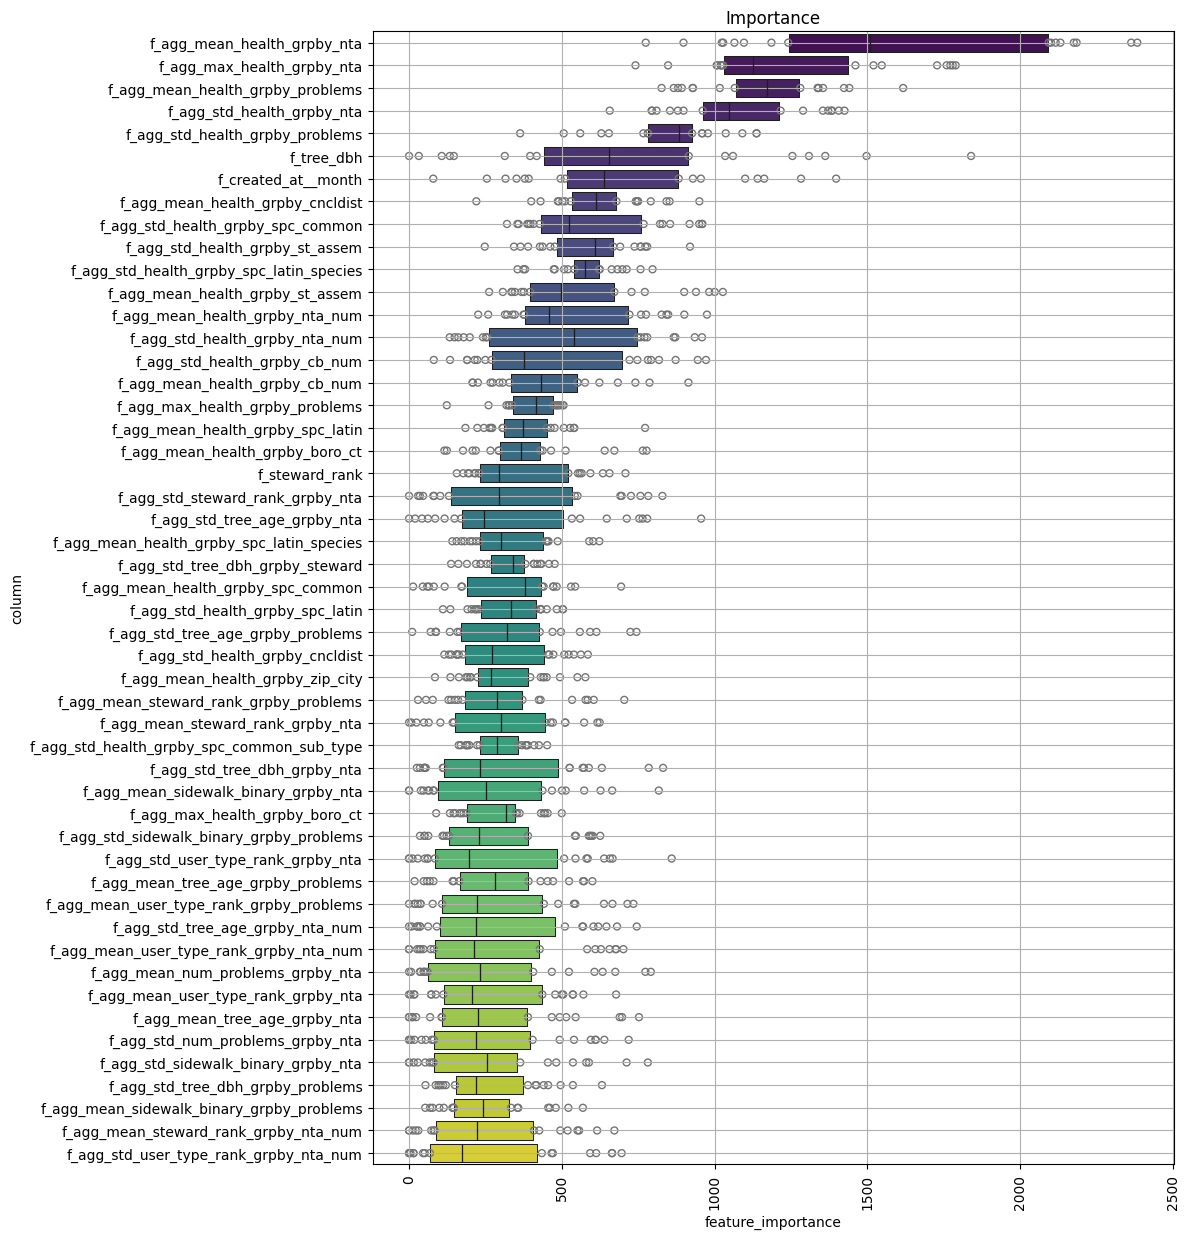

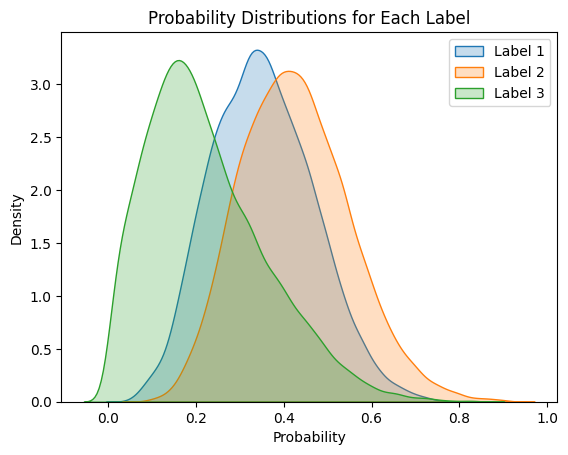

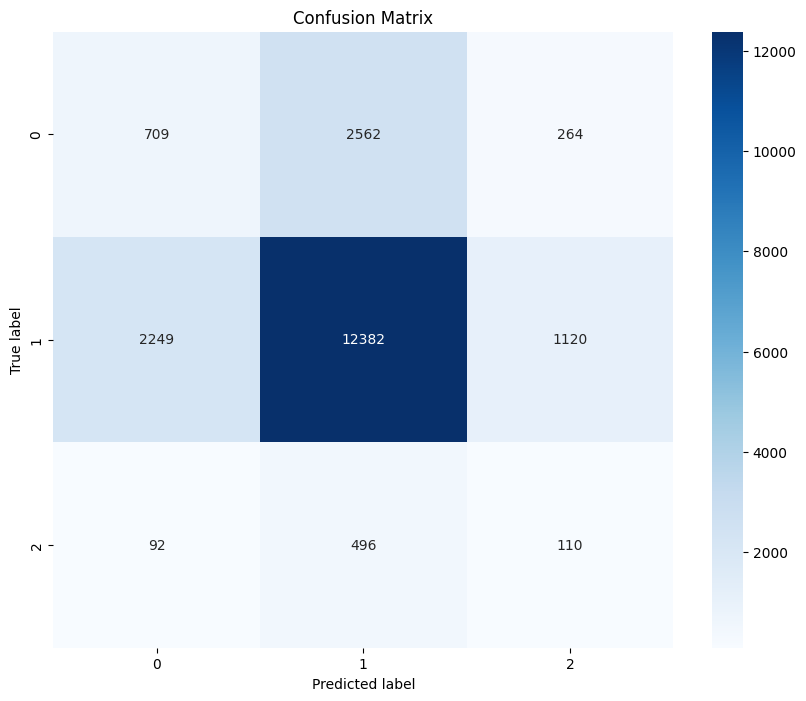

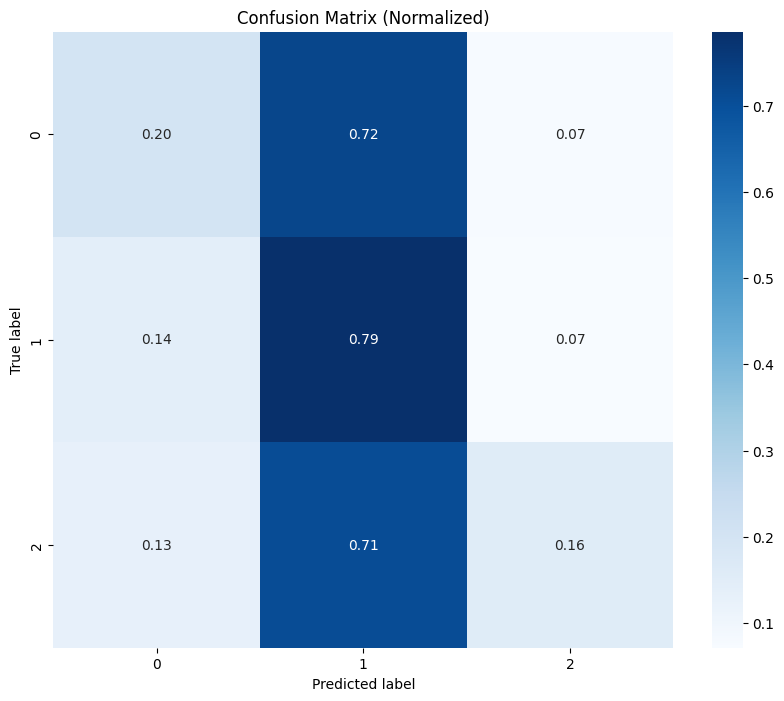

In [8]:
fig, importance_df = visualize_feature_importance(
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    top_n=50,
)
fig.savefig(OUTPUT_DIR / "feature_importance.png", dpi=300)
importance_df.to_csv(OUTPUT_DIR / "feature_importance.csv", index=False)


fig = plot_label_distributions(proba_matrix=np.array(valid_result_df["pred"].tolist()))
fig.show()
fig.savefig(OUTPUT_DIR / "label_distributions.png", dpi=300)


fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label)
fig.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)

fig = plot_confusion_matrix(y_true=valid_result_df["health"], y_pred=val_pred_label, normalize=True)
fig.savefig(OUTPUT_DIR / "confusion_matrix_normalized.png", dpi=300)

### Make submission


In [9]:
test_result_df = predict_cv_tabular_v1(
    df=test_feature_df,
    estimators=all_trained_estimators,
    feature_columns=feature_columns,
    test=True,
    predict_proba=CFG.model.predict_proba,
)

test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["pred"] = np.argmax(test_pred_df.groupby("uid").mean(), axis=1)
submission_df = test_df[["uid", "pred"]]
submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}.csv"
submission_df.to_csv(submission_filepath, index=False, header=False)

fold0 predict : test=True
fold1 predict : test=True
fold2 predict : test=True
fold3 predict : test=True
fold4 predict : test=True
fold5 predict : test=True
fold6 predict : test=True
fold7 predict : test=True
fold8 predict : test=True
fold9 predict : test=True
fold10 predict : test=True
fold11 predict : test=True
fold12 predict : test=True
fold13 predict : test=True
fold14 predict : test=True
fold15 predict : test=True
fold16 predict : test=True
fold17 predict : test=True
fold18 predict : test=True
fold19 predict : test=True
fold20 predict : test=True
fold21 predict : test=True
fold22 predict : test=True
fold23 predict : test=True
fold24 predict : test=True
fold25 predict : test=True
fold26 predict : test=True
fold27 predict : test=True
fold28 predict : test=True
fold29 predict : test=True


In [10]:
test_pred_df = pd.concat([test_result_df[["uid"]], pd.DataFrame(test_result_df["pred"].tolist())], axis=1)
test_df["opt_pred"] = decode_label(proba_matrix=test_pred_df.groupby("uid").mean().to_numpy(), thresholds=opt_results)

submission_filepath = Path(CFG.paths.output_dir) / f"submissions_{CFG.experiment_name}_opt_{best_f1_score:.3f}.csv"
test_df[["uid", "opt_pred"]].to_csv(submission_filepath, index=False, header=False)

joblib.dump(test_pred_df, OUTPUT_DIR / "test_result_df.pkl")

['/Users/masato/Projects/SMBC-Group-GREENxDATA-Challenge/resources/outputs/experiment=022-tabular_v2/test_result_df.pkl']

In [11]:
print(test_df["opt_pred"].value_counts() / len(test_df))

opt_pred
1    0.788042
0    0.145366
2    0.066592
Name: count, dtype: float64


In [12]:
test_df["pred"].value_counts() / len(test_df)

pred
1    0.554461
0    0.305756
2    0.139783
Name: count, dtype: float64

In [13]:
train_df["health"].value_counts() / len(train_df)

health
1    0.788181
0    0.176892
2    0.034928
Name: count, dtype: float64

In [14]:
def plot_dist_by_color(df, value_col, color_col):
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    for color in df[color_col].unique():
        sns.distplot(df[value_col][df[color_col] == color], hist=False, label=color)

    plt.title("Distribution of Values Color-Coded by Color")
    plt.legend()
    plt.show()